In [9]:
import math
import random
import time 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [10]:
class Env:
    def __init__(self, nb_players=2, a_value=2, mu_value=1/4, c_value=1, binary_demand=False):
        self.nb_players = nb_players
        self.a_value = a_value
        self.mu_value = mu_value
        self.c_value = c_value

        self.a = np.concatenate(([0], np.full(nb_players, a_value)))
        self.c = np.full(nb_players, c_value)

        self.binary_demand = binary_demand

    def f(self, p):
        prime_p = np.array([0]+p)
        return np.exp((self.a-prime_p)/self.mu_value)

    def quantity(self, p):
        quant = self.f(p)
        q = np.zeros(len(quant) - 1)
        for i in range(len(quant) - 1):
            q[i] = quant[i + 1] / sum(quant)
        return q

    def binary_quantity(self, p):
        q = np.zeros(len(p))
        # Find indices of minimum prices
        min_indices = np.where(p == np.min(p))[0]

        # Distribute demand equally among players with the lowest prices
        num_min_prices = len(min_indices)
        if num_min_prices > 0:
            q[min_indices] = (self.a[min_indices+1] -
                              np.min(p)) / num_min_prices

        return q

    def __call__(self, p):
        if self.binary_demand:
            return [self.binary_quantity(p), p, self.c]
        else:
            return [self.quantity(p), p, self.c]

In [11]:
env = Env()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
my_neural_network = DQN(2,15).to(device)
state = torch.tensor([2,2], dtype=torch.float32, device=device).unsqueeze(0)
print(my_neural_network(state).max(1)[1].view(1,1).item())
print(my_neural_network(state).max(1)[1].view(1,1))

10
tensor([[10]])


In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

m = 15
A = np.zeros(m)
p1 = 1
pm = 2
for i in range(m):
    A[i] = p1 + i*(pm-p1)/(m-1)
state_space = 15**2 #assuming the agent only know one period of his past


# Get number of actions from gym action space
n_actions = m

# Get the number of state observations
agent1_price = np.random.choice(A)
agent2_price = np.random.choice(A)
quantity, state, costs = env([agent1_price, agent2_price])
n_observations = len(state)


policy_net_agent1 = DQN(n_observations, n_actions).to(device)
target_net_agent1 = DQN(n_observations, n_actions).to(device)
target_net_agent1.load_state_dict(policy_net_agent1.state_dict())

optimizer_agent1 = optim.AdamW(policy_net_agent1.parameters(), lr=LR, amsgrad=True)
memory_agent1 = ReplayMemory(10000)

policy_net_agent2 = DQN(n_observations, n_actions).to(device)
target_net_agent2 = DQN(n_observations, n_actions).to(device)
target_net_agent2.load_state_dict(policy_net_agent2.state_dict())

optimizer_agent2 = optim.AdamW(policy_net_agent2.parameters(), lr=LR, amsgrad=True)
memory_agent2 = ReplayMemory(10000)

steps_done = 0


def select_action(state, policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            print("Exploitation")
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        print("Exploration")
        return torch.tensor([[np.random.randint(15)]], device=device, dtype=torch.long)


rewards_1 = [] #rewards in my case
rewards_2 = [] 


def plot_rewards(show_result=False):
    plt.figure(1)
    rewards1_t = torch.tensor(rewards_1, dtype=torch.float)
    rewards2_t = torch.tensor(rewards_2, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(rewards1_t.numpy())
    plt.plot(rewards2_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards1_t) >= 100:
        means1 = rewards1_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means1))
        plt.plot(means.numpy())
        
    if len(rewards2_t) >= 100:
        means2 = rewards2_t.unfold(0, 100, 1).mean(1).view(-1)
        means2 = torch.cat((torch.zeros(99), means2))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [8]:
def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [31]:
import core.prices as pr
class DeepAgent: 
    def __init__(self, nb_players=2, alpha=1e-4, eps_start=0.9, eps_end=0.05, eps_decay=1000, gamma=0.99, pN=None, pC=None, binary_demand=False, m=15):
        ##Hyperparameters
        self.alpha = alpha
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.batch_size = 128
        self.gamma = gamma
        self.tau = 0.005
        
        ##Size of action and state spaces
        self.m = m
        self.n_state = nb_players
        self.n = nb_players
        
        ##Demand function
        self.binary_demand = binary_demand
        
        ##Action space's definition
        if pN == None or pC == None:
            self.pC, self.pN = self._get_prices()
        else:
            self.pC, self.pN = pC, pN
        self.Xi = 0.1
        self.p1 = self.pN-self.Xi*(self.pC-self.pN)
        self.pm = self.pC+self.Xi*(self.pC-self.pN)
        self.A = np.zeros(self.m)
        for i in range(self.m):
            self.A[i] = self.p1 + i*(self.pm-self.p1)/(self.m-1)
            
        #Selected action and associated index
        self.p = None 
        self.a_ind = None
        
        #State and reward, given by the environment 
        self.state = None
        self.reward = None 
        
        #Neural networks
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(policy_net_agent1.state_dict())
        
        #Optimizer and memory
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.alpha, amsgrad=True)
        self.memory = ReplayMemory(10000)
        
    def _get_prices(self):
        prices = pr.PriceOptimizer(
            nb_players=self.n, binary_demand=self.binary_demand)
        collusion_price, nash_price = prices()
        return collusion_price, nash_price
        
    def get_next_action(self, t):
        '''Return the index of the selected action'''
        sample = random.random()
        self.eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1. * t / self.eps_decay)
        if sample > self.eps_threshold:
            with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[np.random.randint(15)]], device=device, dtype=torch.long)
        
    def optimize_model(self, device):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
    def update_network(self):
        self.target_net_state_dict = self.target_net.state_dict()
        self.policy_net_state_dict = self.policy_net.state_dict()
        for key in self.policy_net_state_dict:
            self.target_net_state_dict[key] = self.policy_net_state_dict[key]*self.tau
            + self.target_net_state_dict[key]*(1-self.tau)
            target_net_agent1.load_state_dict(self.target_net_state_dict)

In [15]:
def plot_rewards(rewards, show_result=False):
    plt.figure(1)
    for i in len(rewards[0]):
        rewards1_t = torch.tensor(rewards_1, dtype=torch.float)
    rewards2_t = torch.tensor(rewards_2, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(rewards1_t.numpy())
    plt.plot(rewards2_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards1_t) >= 100:
        means1 = rewards1_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means1))
        plt.plot(means.numpy())
        
    if len(rewards2_t) >= 100:
        means2 = rewards2_t.unfold(0, 100, 1).mean(1).view(-1)
        means2 = torch.cat((torch.zeros(99), means2))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [48]:
def plot_learningcurve(rewards):
    num_players = len(rewards[0])

    # Plot curves for each player in the subplot
    for player in range(num_players):
        plt.plot(rewards[:, player], alpha=0.5, label=f'Player {player + 1}')


    # Display the figure
    plt.title('Learning curves')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.legend()
    plt.show()

In [51]:
if torch.cuda.is_available():
    nb_iterations = 1000000
else:
    nb_iterations = 100000

for loop in range(1):
    print("Loop:", loop)
    agents = [DeepAgent() for _ in range(2)]
    env = Env()
    temps = []
    rewards = []
    epsilon = []
    prices = []

    # Initialization of prices p0 (done directly in each agent)
    for agent in agents:
        agent.p = np.random.choice(agent.A)
        
    quantity, state, costs = env([agent.p for agent in agents])
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # Iterative phase
    for t in range(nb_iterations):
        if t % (2*10**5) == 0:
            inter_start = time.time()
            print("t:", t)
        # Actions and state at t+1
        for agent in agents:
            agent.a_ind = agent.get_next_action(t)
            agent.p = A[agent.a_ind.item()]
            
        quantity, obs, costs = env([agent.p for agent in agents])
        re = quantity*obs - quantity*costs
        rewards.append(re)
        temps.append(t)
        epsilon.append(agents[0].eps_threshold)
        prices.append([agent.p for agent in agents])
        
        for i, agent in enumerate(agents): 
            agent.reward = torch.tensor([quantity[i]*obs[i] - quantity[i]*costs[i]], device=device)
    
        next_state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        for agent in agents:
            agent.memory.push(state, agent.a_ind, next_state, agent.reward)

        # Move to the next state
        state = next_state

        for agent in agents: 
            # Perform one step of the optimization (on the policy network)
            agent.optimize_model(device)

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            agent.update_network()

rewards = np.vstack(rewards)
print('Complete')
plot_learningcurve(rewards)
plt.ioff()
plt.show()

Loop: 0
t: 0


KeyboardInterrupt: 

Complete


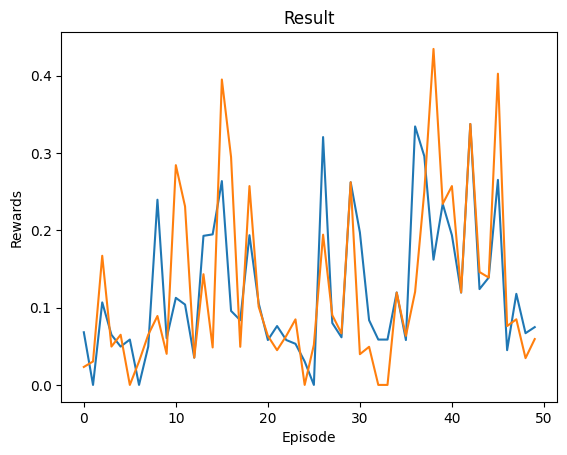

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [139]:
if torch.cuda.is_available():
    num_episodes = 10
else:
    num_episodes = 5

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    agent1_price = np.random.choice(A)
    agent2_price = np.random.choice(A)
    quantity, state, costs = env([agent1_price, agent2_price])
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in range(10):#to adjust
        agent1_index = select_action(state, policy_net_agent1)
        agent2_index = select_action(state, policy_net_agent2)
        agent1_price = A[agent1_index.item()]
        agent2_price = A[agent2_index.item()]
        print(agent1_price, agent2_price)
        quantity, obs, costs = env([agent1_price, agent2_price])
        agent1_reward = torch.tensor([quantity[0]*obs[0] - quantity[0]*costs[0]], device=device)
        agent2_reward = torch.tensor([quantity[1]*obs[1] - quantity[1]*costs[1]], device=device)
        
        next_state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory_agent1.push(state, agent1_index, next_state, agent1_reward)
        memory_agent2.push(state, agent2_index, next_state, agent2_reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model(memory_agent1, policy_net_agent1, target_net_agent1, optimizer_agent1)
        optimize_model(memory_agent2, policy_net_agent2, target_net_agent2, optimizer_agent2)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        agent1_target_net_state_dict = target_net_agent1.state_dict()
        agent1_policy_net_state_dict = policy_net_agent1.state_dict()
        print(agent1_policy_net_state_dict)
        for key in agent1_policy_net_state_dict:
            print(key)
            agent1_target_net_state_dict[key] = agent1_policy_net_state_dict[key]*TAU 
            + agent1_target_net_state_dict[key]*(1-TAU)
            target_net_agent1.load_state_dict(agent1_target_net_state_dict)
            
        agent2_target_net_state_dict = target_net_agent2.state_dict()
        agent2_policy_net_state_dict = policy_net_agent2.state_dict()
        for key in agent2_policy_net_state_dict:
            agent2_target_net_state_dict[key] = agent2_policy_net_state_dict[key]*TAU 
            + agent2_target_net_state_dict[key]*(1-TAU)
            target_net_agent2.load_state_dict(agent2_target_net_state_dict)

        rewards_1.append(agent1_reward)
        rewards_2.append(agent2_reward)
        plot_rewards()

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()